In [ ]:
import os
import sys
import h5py
import numpy as np
import torch
# import BART
os.environ['TOOLBOX_PATH'] = "/home/svangurp/scratch/samuel/bart-0.6.00/"
sys.path.append('/home/svangurp/scratch/samuel/bart-0.6.00/python/')
import bart
import fastmri.data.transforms as T
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri import tensor_to_complex_np
import matplotlib.pyplot as plt

In [ ]:

# open file
fname = '/scratch/svangurp/samuel/data/knee/train/file1000002.h5'
# read h5 file
data = h5py.File(fname, 'r')
# extract the multi coil k-space data
kspace = data["kspace"][()]
# selecting a single slice to work on
slice = 20

target = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace[slice], axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))

# RSS combination
target = np.sqrt(np.sum(T.center_crop(target, (320, 320)) ** 2, 0))

crop_size = (320, 320)

# applying a random mask
mask_func = create_mask_for_mask_type(mask_type_str="random", center_fractions=[0.08], accelerations=[4])

# transforming one slice of the multi coil k-space data
_kspace = T.to_tensor(kspace)[slice]
# applying the mask to the one slice of the multi coil k-space data
masked_kspace, mask = T.apply_mask(_kspace, mask_func)

# splitting the values 
linear_recon = masked_kspace[..., 0] + 1j * masked_kspace[..., 1]
# going to image space
linear_recon = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(linear_recon, axes=(-2, -1)), axes=(-2, -1)),

                               axes=(-2, -1))
# RSS coil combination 
linear_recon = np.sqrt(np.sum(T.center_crop(linear_recon, (320, 320)) ** 2, 0))

# like fftshift 
masked_kspace = masked_kspace.permute(1, 2, 0, 3).unsqueeze(0)


masked_kspace = tensor_to_complex_np(masked_kspace)
# estemating the sens maps
sens_maps = bart.bart(1, "ecalib -d0 -m1", masked_kspace)

# parameters for the reconstruction
reg_wt = 0.01
num_iters = 200

pred = bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", masked_kspace, sens_maps)

pred = torch.from_numpy(np.abs(pred[0]))

# check for FLAIR 203

if pred.shape[1] < crop_size[1]:

    crop_size = (pred.shape[1], pred.shape[1])

pred = T.center_crop(pred, crop_size)

print('Done')

In [ ]:

# plotting
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 3, 1)

plt.imshow(np.abs(target), cmap='gray')

plt.title('Fully-sampled')

plt.subplot(1, 3, 2)

plt.imshow(np.abs(linear_recon), cmap='gray')

plt.title('4x')

plt.subplot(1, 3, 3)

plt.imshow(np.abs(pred), cmap='gray')

plt.title('PICS')

plt.show()


In [ ]:
diff_4x = np.sqrt(np.subtract(target,linear_recon)**2)
rms_err_4x = abs(sum(sum(diff_4x)))
print(rms_err_4x)

diff_pics = np.sqrt(np.subtract(target,pred)**2)
rms_err_pics = abs(sum(sum(diff_pics)))
print(rms_err_pics)

In [ ]:
def tensor_to_array(tensor):
    #  takes 2d tensor
    height, width = tensor.shape
    array = np.zeros((height, width))
    
    for i in range(0,height-1):
        for j in range(0,width-1):
            element = tensor[i,j]
            array[i,j] = abs(element)
           
            
    return array


In [ ]:
# calculate the differens from the recon to the fully sampled data, and calculate the rms error

diff_4x = np.sqrt(abs(np.subtract(target,linear_recon))**2)

rms_err_4x = abs(sum(sum(diff_4x)))
print(rms_err_4x)


# pred_array = tensor_to_array(pred)

diff_pics = np.sqrt(np.subtract(target,pred)**2)
rms_err_pics = abs(sum(sum(diff_pics)))
print(rms_err_pics)


In [ ]:
diff_4x = np.subtract(target,linear_recon)
diff_pics = np.subtract(target,pred_array)

# plotting
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 3, 1)

plt.imshow(np.abs(target), cmap='gray')

plt.title('Fully-sampled')

plt.subplot(1, 3, 2)

plt.imshow(np.abs(diff_4x), cmap='gray')

plt.title('diff 4x')

plt.subplot(1, 3, 3)

plt.imshow(np.abs(diff_pics), cmap='gray')

plt.title('diff PICS')

plt.show()


In [ ]:
diff_4x = np.array(abs(np.subtract(target,linear_recon)))
diff_pics = np.array(abs(np.subtract(target,pred)))


diff_4x_norm = diff_4x /np.max(diff_4x)
diff_pics_norm = diff_pics / np.max(diff_pics)
target_norm = target / np.max(target)

In [ ]:
fname = '/scratch/svangurp/samuel/data/knee/train/file1000002.h5'
data = h5py.File(fname, 'r')
kspace = data["kspace"][()]


slice = 20
crop_size = (320, 320)
device = 'cuda'

In [ ]:
imspace = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
imspace = T.center_crop(imspace, crop_size) 
imspace = imspace / np.max(np.abs(imspace))

kspace = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(imspace, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))

print(imspace.shape, np.min(np.abs(imspace)), np.max(np.abs(imspace)))

In [ ]:
target = np.sqrt(np.sum(imspace**2, 1))
target = target / np.max(np.abs(target))

print(np.min(np.abs(target)), np.max(np.abs(target)))

In [ ]:
mask_func = create_mask_for_mask_type(mask_type_str="random", center_fractions=[0.08], accelerations=[4])
masked_kspace, mask = T.apply_mask(T.to_tensor(kspace), mask_func)

In [ ]:
masked_kspace = torch.view_as_complex(masked_kspace)
masked_kspace.shape

In [ ]:
linear_recon = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(masked_kspace.detach().cpu().numpy(), 
                                                             axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
linear_recon = np.sqrt(np.sum(linear_recon ** 2, 1))
linear_recon = linear_recon / np.max(np.abs(linear_recon))
print(np.min(np.abs(linear_recon)), np.max(np.abs(linear_recon)))

In [ ]:
_masked_kspace = masked_kspace.permute(0, 2, 3, 1).detach().cpu().numpy()
sens_maps = bart.bart(1, "ecalib -d0 -m1", _masked_kspace)
print(np.min(np.abs(sens_maps)), np.max(np.abs(sens_maps)))

In [ ]:
tmp_sens_maps = np.fft.ifft2(np.fft.fftshift(np.fft.fft2(sens_maps[slice], axes=(-3, -2)), axes=(-3, -2)), axes=(-3, -2))
tmp_imspace = np.fft.ifft2(np.fft.fftshift(_masked_kspace[slice], axes=(-3, -2)), axes=(-3, -2))

tmp_target = np.sum(tmp_imspace*tmp_sens_maps.conj(), -1)
plt.imshow(np.abs(tmp_target), cmap='gray')
plt.show()

In [ ]:
reg_wt = 0.01
num_iters = 20

tmp_masked_kspace = np.fft.fftshift(np.expand_dims(_masked_kspace[slice], 0), axes=(-3, -2))

pred = np.abs(bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", 
                        tmp_masked_kspace, np.expand_dims(sens_maps[slice], 0)))
# pred = pred / np.max(np.abs(pred))
pred = np.abs(pred[0])

In [ ]:
plt.imshow(pred, cmap='gray')
plt.show()

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

_target = np.abs(target[slice])
_target = _target / np.max(np.abs(_target))

_linear_recon = np.abs(linear_recon[slice])
_linear_recon = _linear_recon / np.max(np.abs(_linear_recon))

print(np.max(_target), np.max(_linear_recon))

SSIM_pics = structural_similarity(_target, _linear_recon, data_range=np.max(_target), multichannel=True)
print(SSIM_pics)

In [ ]:
reg_wt = 0.01
num_iters = 20

pred = np.abs(bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", 
                        np.fft.ifftshift(_masked_kspace, axes=(-3, -2)), sens_maps))
pred = pred / np.max(np.abs(pred))
print(np.min(np.abs(pred)), np.max(np.abs(pred)))

In [ ]:
print(target.shape, pred.shape, linear_recon.shape)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

_target = np.expand_dims(np.abs(target[slice]), -1)
_target = _target / np.max(np.abs(_target))

_pred = np.expand_dims(np.abs(pred[slice]), -1)
_pred = _pred / np.max(np.abs(_pred))

_linear_recon = np.expand_dims(np.abs(linear_recon[slice]), -1)
_linear_recon = _linear_recon / np.max(np.abs(_linear_recon))

print(np.max(_target), np.max(_pred), np.max(_linear_recon))

SSIM_pics = structural_similarity(_target, _pred, data_range=np.max(_target), multichannel=True)
SSIM_lin_recon = structural_similarity(_target, _linear_recon, data_range=np.max(_target), multichannel=True)

print('SSIM_pics:',SSIM_pics)
print('SSIM_lin_recon:', SSIM_lin_recon)

print(peak_signal_noise_ratio(_target, _pred, data_range=np.max(_target)))
print(peak_signal_noise_ratio(_target, _linear_recon, data_range=np.max(_target)))

In [ ]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 5, 1)
plt.imshow(np.abs(target[slice]), cmap='gray')
plt.title('Fully-sampled')
plt.subplot(1, 5, 2)
plt.imshow(np.abs(linear_recon[slice]), cmap='gray')
plt.title('4x')
plt.subplot(1, 5, 3)
plt.imshow(np.abs(target[slice])-np.abs(linear_recon[slice]), cmap='gray')
plt.title('dif')
plt.subplot(1, 5, 4)
plt.imshow(np.abs(pred[slice]), cmap='gray')
plt.title('PICS')
plt.subplot(1, 5, 5)
plt.imshow(np.abs(target[slice])-np.abs(pred[slice]), cmap='gray')
plt.title('PICS dif')
plt.show()

In [ ]:




fname = '/scratch/svangurp/samuel/data/knee/train/file1000002.h5'
data = h5py.File(fname, 'r')

kspace = data["kspace"][()]


slice = 20

crop_size = (320, 320)

device = 'cuda'



target = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace[slice], axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))

target = np.sqrt(np.sum(T.center_crop(target, crop_size) ** 2, 0))



target = target / np.max(np.abs(target))


crop_size = (320, 320)

mask_func = create_mask_for_mask_type(mask_type_str="random", center_fractions=[0.08], accelerations=[4])


_kspace = T.to_tensor(kspace)[slice]

masked_kspace, mask = T.apply_mask(_kspace, mask_func)



linear_recon = masked_kspace[..., 0] + 1j * masked_kspace[..., 1]

linear_recon = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(linear_recon, axes=(-2, -1)), axes=(-2, -1)),

                               axes=(-2, -1))

linear_recon = np.sqrt(np.sum(T.center_crop(linear_recon, (320, 320)) ** 2, 0))

linear_recon = linear_recon / np.max(np.abs(linear_recon))


masked_kspace = masked_kspace.permute(1, 2, 0, 3).unsqueeze(0)

masked_kspace = tensor_to_complex_np(masked_kspace)



sens_maps = bart.bart(1, "ecalib -d0 -m1", masked_kspace)



reg_wt = 0.001

num_iters = 20

pred = np.abs(bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", masked_kspace, sens_maps)[0])


# check for FLAIR 203

if pred.shape[1] < crop_size[1]:

    crop_size = (pred.shape[1], pred.shape[1])



pred = T.center_crop(pred, crop_size)

pred = torch.from_numpy(pred / np.max(np.abs(pred))).cpu().numpy()




In [ ]:
plt.imshow(pred, cmap='gray')
plt.show()

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

_target = np.abs(target[slice])
_target = _target / np.max(np.abs(_target))

_linear_recon = np.abs(linear_recon[slice])
_linear_recon = _linear_recon / np.max(np.abs(_linear_recon))

print(np.max(_target), np.max(_linear_recon))

SSIM_pics = structural_similarity(_target, _linear_recon, data_range=np.max(_target), multichannel=True)
print(SSIM_pics)

In [ ]:
reg_wt = 0.01
num_iters = 20

pred = np.abs(bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", 
                        np.fft.ifftshift(_masked_kspace, axes=(-3, -2)), sens_maps))
pred = pred / np.max(np.abs(pred))
print(np.min(np.abs(pred)), np.max(np.abs(pred)))

In [ ]:
print(target.shape, pred.shape, linear_recon.shape)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

_target = np.expand_dims(np.abs(target[slice]), -1)
_target = _target / np.max(np.abs(_target))

_pred = np.expand_dims(np.abs(pred[slice]), -1)
_pred = _pred / np.max(np.abs(_pred))

_linear_recon = np.expand_dims(np.abs(linear_recon[slice]), -1)
_linear_recon = _linear_recon / np.max(np.abs(_linear_recon))

print(np.max(_target), np.max(_pred), np.max(_linear_recon))

SSIM_pics = structural_similarity(_target, _pred, data_range=np.max(_target), multichannel=True)
SSIM_lin_recon = structural_similarity(_target, _linear_recon, data_range=np.max(_target), multichannel=True)

print('SSIM_pics:',SSIM_pics)
print('SSIM_lin_recon:', SSIM_lin_recon)

print(peak_signal_noise_ratio(_target, _pred, data_range=np.max(_target)))
print(peak_signal_noise_ratio(_target, _linear_recon, data_range=np.max(_target)))

In [ ]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 5, 1)
plt.imshow(np.abs(target[slice]), cmap='gray')
plt.title('Fully-sampled')
plt.subplot(1, 5, 2)
plt.imshow(np.abs(linear_recon[slice]), cmap='gray')
plt.title('4x')
plt.subplot(1, 5, 3)
plt.imshow(np.abs(target[slice])-np.abs(linear_recon[slice]), cmap='gray')
plt.title('dif')
plt.subplot(1, 5, 4)
plt.imshow(np.abs(pred[slice]), cmap='gray')
plt.title('PICS')
plt.subplot(1, 5, 5)
plt.imshow(np.abs(target[slice])-np.abs(pred[slice]), cmap='gray')
plt.title('PICS dif')
plt.show()

In [26]:




fname = '/scratch/svangurp/samuel/data/knee/train/file1000002.h5'
data = h5py.File(fname, 'r')

kspace = data["kspace"][()]


slice = 20

crop_size = (320, 320)

device = 'cuda'



target = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace[slice], axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))

target = np.sqrt(np.sum(T.center_crop(target, crop_size) ** 2, 0))



target = target / np.max(np.abs(target))


crop_size = (320, 320)

mask_func = create_mask_for_mask_type(mask_type_str="random", center_fractions=[0.08], accelerations=[4])


_kspace = T.to_tensor(kspace)[slice]

masked_kspace, mask = T.apply_mask(_kspace, mask_func)



linear_recon = masked_kspace[..., 0] + 1j * masked_kspace[..., 1]

linear_recon = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(linear_recon, axes=(-2, -1)), axes=(-2, -1)),

                               axes=(-2, -1))

linear_recon = np.sqrt(np.sum(T.center_crop(linear_recon, (320, 320)) ** 2, 0))

linear_recon = linear_recon / np.max(np.abs(linear_recon))


masked_kspace = masked_kspace.permute(1, 2, 0, 3).unsqueeze(0)

masked_kspace = tensor_to_complex_np(masked_kspace)



sens_maps = bart.bart(1, "ecalib -d0 -m1", masked_kspace)



reg_wt = 0.001

num_iters = 20

pred = np.abs(bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", masked_kspace, sens_maps)[0])


# check for FLAIR 203

if pred.shape[1] < crop_size[1]:

    crop_size = (pred.shape[1], pred.shape[1])



pred = T.center_crop(pred, crop_size)

pred = torch.from_numpy(pred / np.max(np.abs(pred))).cpu().numpy()




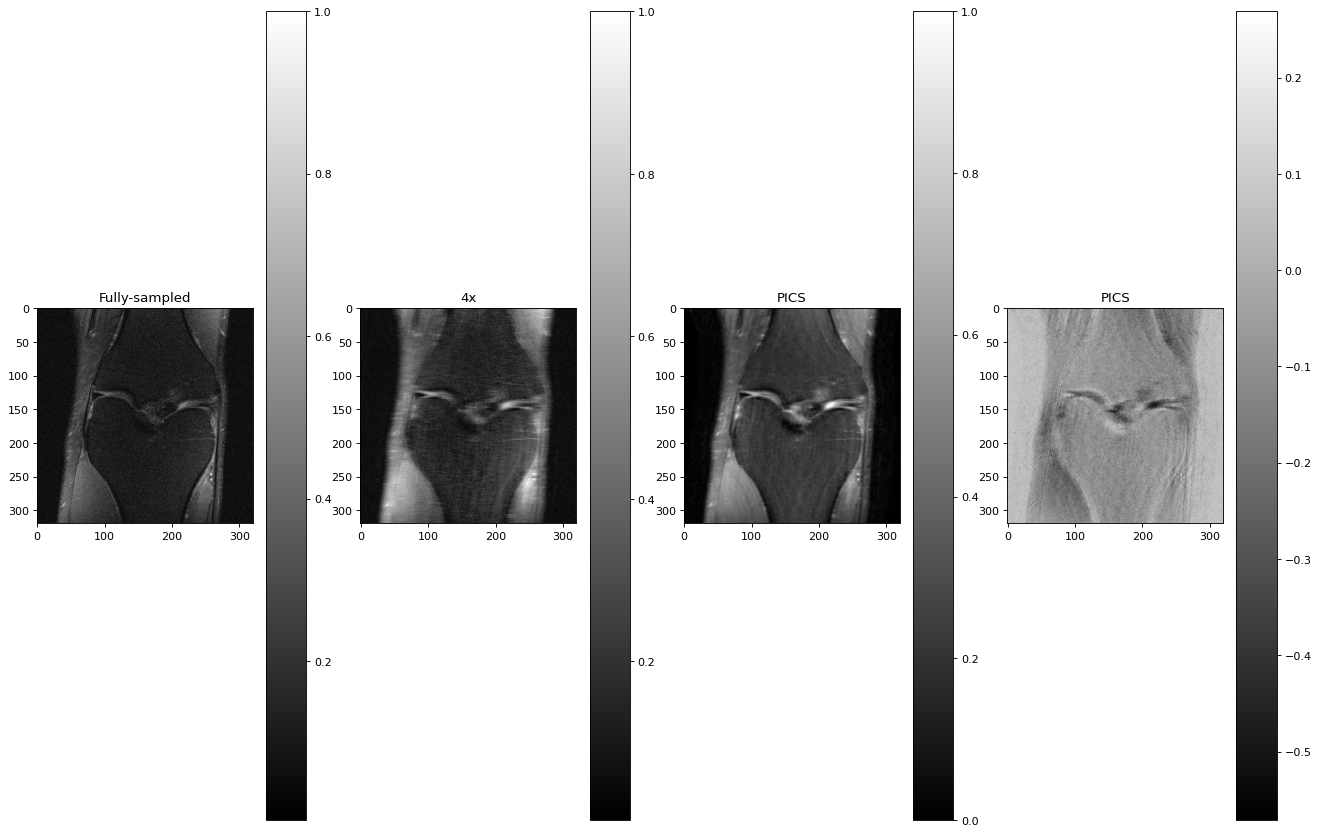

<function print>

In [16]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 4, 1)

plt.imshow(np.abs(target), cmap='gray')

plt.title('Fully-sampled')

plt.colorbar()

plt.subplot(1, 4, 2)

plt.imshow(np.abs(linear_recon), cmap='gray')

plt.title('4x')

plt.colorbar()

plt.subplot(1, 4, 3)

plt.imshow(np.abs(pred), cmap='gray')

plt.title('PICS')

plt.colorbar()

plt.subplot(1, 4, 4)

plt.imshow(np.abs(target)-np.abs(pred), cmap='gray')

plt.title('PICS')

plt.colorbar()

plt.show()
print


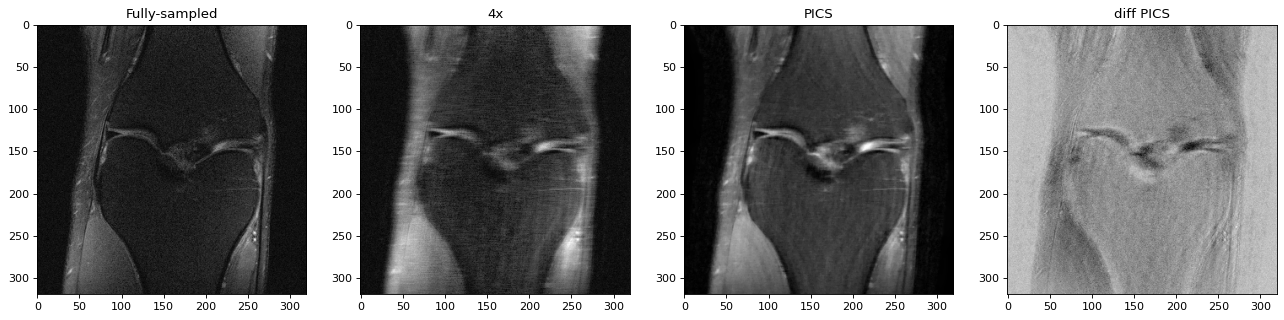

In [17]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 4, 1)

plt.imshow(np.abs(target), cmap='gray')

plt.title('Fully-sampled')

plt.subplot(1, 4, 2)

plt.imshow(np.abs(linear_recon), cmap='gray')

plt.title('4x')


plt.subplot(1, 4, 3)

plt.imshow(np.abs(pred), cmap='gray')

plt.title('PICS')


plt.subplot(1, 4, 4)

plt.imshow(np.abs(target)-np.abs(pred), cmap='gray')

plt.title('diff PICS')


plt.show()



In [27]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

target = np.abs(target / np.max(np.abs(target)))
pred = np.abs(pred / np.max(np.abs(pred)))
linear_recon = np.abs(linear_recon / np.max(np.abs(linear_recon)))

print(target.shape, pred.shape, linear_recon.shape)
_target = np.expand_dims(target, -1)
_pred = np.expand_dims(pred, -1)
_linear_recon = np.expand_dims(linear_recon, -1)
print(_target.shape, _pred.shape, _linear_recon.shape)


SSIM_pics = structural_similarity((_target), (_pred), data_range= np.max(_target), multichannel=True)
SSIM_lin_recon = structural_similarity((_target), (_linear_recon),data_range= np.max(_target), multichannel=True)

print('SSIM_pics:',SSIM_pics)
print('SSIM_lin_recon:', SSIM_lin_recon)

(320, 320) (320, 320) (320, 320)
(320, 320, 1) (320, 320, 1) (320, 320, 1)
SSIM_pics: 0.45970086744579025
SSIM_lin_recon: 0.5384433735355093


In [ ]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 3, 1)

plt.imshow(np.abs(target), cmap='gray')

plt.title('Fully-sampled')

plt.subplot(1, 3, 2)

plt.imshow(np.abs(target)-np.abs(linear_recon), cmap='gray')

plt.title('diff 4x')



plt.subplot(1, 3, 3)

plt.imshow(np.abs(target)-np.abs(pred), cmap='gray')

plt.title('diff PICS')


plt.show()

